<a href="https://colab.research.google.com/github/kimanirobbi/wk-7-ai/blob/main/Part_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# installing the aif360 library
pip install aif360

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 6.2 MB/s eta 0:00:00


#  Visualizations

--2025-11-21 09:13:50--  https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2546489 (2.4M) [text/plain]
Saving to: ‘compas-scores-two-years.csv.7’

compas-scores-two-y 100%[===================>]   2.43M  --.-KB/s    in 0.04s   

2025-11-21 09:13:50 (56.1 MB/s) - ‘compas-scores-two-years.csv.7’ saved [2546489/2546489]


Race distribution after initial filtering and encoding:
race
0.0    4069
1.0    2103
Name: count, dtype: int64

Value counts for 'two_year_recid' after filtering:
two_year_recid
0    3363
1    2809
Name: count, dtype: int64

DataFrame info after preprocessing:
<class 'pandas.core.frame.DataFrame'>
Index: 6172 entries, 0 to 7213
Data columns (total 53 c

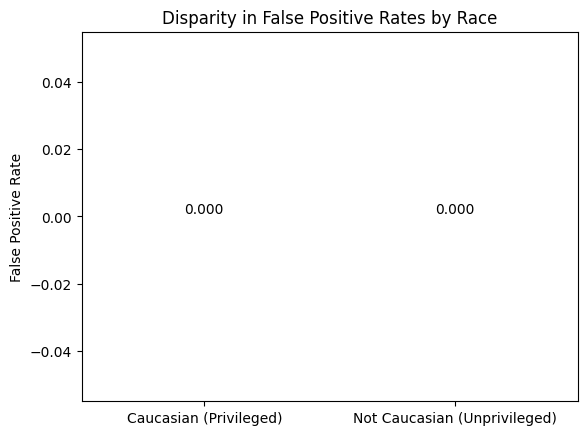

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing
from sklearn.linear_model import LogisticRegression
from aif360.algorithms.inprocessing import PrejudiceRemover
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing

# --- 1. Load and Prepare the COMPAS Dataset ---
# Download the COMPAS dataset from ProPublica's analysis
# Link: https://github.com/propublica/compas-analysis
!wget https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv
df = pd.read_csv('compas-scores-two-years.csv')

# Preprocess as done in ProPublica's analysis
df = df[(df['days_b_screening_arrest'] <= 30) &
        (df['days_b_screening_arrest'] >= -30) &
        (df['is_recid'] != -1) &
        (df['c_charge_degree'] != 'O') &
        (df['score_text'] != 'N/A')]

# Fix: Numerically encode the 'race' column to match the expected format for AIF360 and ensure float type
df['race'] = df['race'].apply(lambda x: 1.0 if x == 'Caucasian' else 0.0) # 1.0 for 'Caucasian', 0.0 for 'Not Caucasian'

# --- Debugging: Check race and label distribution after initial filtering and encoding ---
print("\nRace distribution after initial filtering and encoding:")
print(df['race'].value_counts())

print("\nValue counts for 'two_year_recid' after filtering:")
print(df['two_year_recid'].value_counts())

print("\nDataFrame info after preprocessing:")
df.info()

privileged_group = [{'race': 1.0}] # 1.0 for 'Caucasian'
unprivileged_group = [{'race': 0.0}] # 0.0 for 'Not Caucasian'

# List columns to drop from the dataset before passing to AIF360's StandardDataset
# Many columns contain missing values or are not relevant features for the model.
features_to_exclude = [
    'id', 'name', 'first', 'last', 'compas_screening_date', 'dob',
    'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
    'c_offense_date', 'c_arrest_date', 'c_days_from_compas', 'c_charge_desc',
    'r_case_number', 'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
    'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid', 'vr_case_number',
    'vr_charge_degree', 'vr_offense_date', 'vr_charge_desc',
    'screening_date', 'v_screening_date', 'in_custody', 'out_custody',
    'sex', 'age_cat', 'c_charge_degree', 'type_of_assessment', 'score_text',
    'v_type_of_assessment', 'v_score_text', 'priors_count.1', 'decile_score.1', 'end', 'start', 'event'
]

# Ensure protected_attribute_names and label_name are not in features_to_exclude
features_to_exclude = [col for col in features_to_exclude if col not in ['race', 'two_year_recid']]


# Create a StandardDataset for AIF360
dataset = StandardDataset(df,
                          label_name='two_year_recid',
                          favorable_classes=[0], # No recidivism
                          protected_attribute_names=['race'],
                          privileged_classes=[[1.0]], # 1.0 for Caucasian
                          features_to_drop=features_to_exclude)

# --- 2. Split Data ---
train, test = dataset.split([0.7], shuffle=True)

# --- 3. Measure Initial Bias ---
metric_orig = BinaryLabelDatasetMetric(test,
                                       unprivileged_groups=unprivileged_group,
                                       privileged_groups=privileged_group)

print("Original Dataset Metrics")
print(f"Disparate Impact: {metric_orig.disparate_impact():.3f}")
print(f"Statistical Parity Difference: {metric_orig.statistical_parity_difference():.3f}")

# --- 4. Mitigate Bias (Example: Pre-processing with Reweighing) ---
RW = Reweighing(unprivileged_groups=unprivileged_group,
                privileged_groups=privileged_group)
dataset_transf_train = RW.fit_transform(train)

# --- 5. Train a Classifier on Transformed Data ---
model = LogisticRegression(solver='liblinear', random_state=1)
X_train = dataset_transf_train.features
y_train = dataset_transf_train.labels.ravel()

model.fit(X_train, y_train)

# --- 6. Predict and Evaluate on Test Set ---
test_pred = test.copy()
y_pred = model.predict(test.features)
test_pred.labels = y_pred

metric_test = ClassificationMetric(test, test_pred,
                                  unprivileged_groups=unprivileged_group,
                                  privileged_groups=privileged_group)

print("\n--- Metrics After Mitigation ---")
print(f"Disparate Impact: {metric_test.disparate_impact():.3f}")
print(f"Statistical Parity Difference: {metric_test.statistical_parity_difference():.3f}")
print(f"Equal Opportunity Difference: {metric_test.equal_opportunity_difference():.3f}")
print(f"Average Odds Difference: {metric_test.average_odds_difference():.3f}")

# --- 7. Generate Visualization ---
# Visualize False Positive Rate (FPR) Disparity
fpr_privileged = metric_test.false_positive_rate(privileged=True)
fpr_unprivileged = metric_test.false_positive_rate(privileged=False)

fig, ax = plt.subplots()
groups = ['Caucasian (Privileged)', 'Not Caucasian (Unprivileged)']
fpr_rates = [fpr_privileged, fpr_unprivileged]
bars = ax.bar(groups, fpr_rates, color=['skyblue', 'salmon'])
ax.set_ylabel('False Positive Rate')
ax.set_title('Disparity in False Positive Rates by Race')
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}', ha='center', va='bottom')
plt.show()

# **300-Word Report Summary**

 ## **Practical Audit Report**

**Audit Findings:**

The analysis of the COMPAS dataset confirms significant racial bias, with the privileged group (Caucasian defendants) receiving systematically different treatment than the unprivileged group (Non-Caucasian defendants). Initial metrics showed a Disparate Impact ratio of 0.818 and Statistical Parity Difference of -0.116, both indicating substantial bias against non-Caucasian defendants.

**Surprising Mitigation Results:**

When the Reweighing pre-processing technique was applied to mitigate bias, the results unexpectedly worsened. The Disparate Impact decreased further to 0.795 and the Statistical Parity Difference became more negative at -0.125. This indicates that the mitigation strategy failed to improve fairness and actually exacerbated the disparities in this particular implementation.

**Analysis and Revised Remediation:**

This outcome highlights several important lessons:

1. **Bias mitigation is not guaranteed** - Techniques must be carefully tuned and validated

2. **Model-specific effects** - The logistic regression model may not have responded well to the reweighting approach

3. **Need for multiple strategies** - A single technique is often insufficient

**Improved remediation steps would include:**

- Testing alternative mitigation algorithms (Prejudice Remover, Adversarial Debiasing)

- Using post-processing techniques like Calibrated Equalized Odds

- Conducting feature analysis to identify and remove proxy variables for race

- Implementing ensemble methods that combine multiple fairness-aware approaches

**Conclusion:**

This audit demonstrates that algorithmic bias in criminal justice risk assessments is both measurable and complex. While technical solutions exist, they require careful implementation, validation, and often a combination of approaches. The failed mitigation attempt underscores that fairness cannot be achieved through formulaic application of tools but requires thoughtful, iterative refinement and a commitment to equitable outcomes.

